In [118]:
import dimod
import neal
import math
from pyqubo import Array, Placeholder, solve_qubo, Constraint
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

## Graphics

In [119]:
def plot_enumerate(results, title=None):
    plt.figure()
    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('Solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

## Parameters

In [120]:
T = 5 # number of days
M = 1 # number of materials
S = 1 # ship models

C = {} # material consumptions
C[0] = [2] # material consumptions for day 0 (length M)
C[1] = [2] # material consumptions for day 1 (length M)
C[2] = [2] # material consumptions for day 2 (length M)
C[3] = [2] # material consumptions for day 3 (length M)
C[4] = [2] # material consumptions for day 4 (length M)

B = {} # ship capacities
B[0] = [3] # ship capacities for material 0 (length S)

n = {} # time units required for a journey
n[0] = [2] # time units required for a journey for material 0 (length S)

# Initialize Stock
S0 = [6] # initial stock per material
SF = [2] # minimum final stock per material
Y = 2 # maximum stockout
a = math.ceil(math.log(Y+1,2))
Z = 6   # maximum stock
b = math.ceil(math.log(Z+1,2))

# Costs
c_inv = [5] # inventary costs per material
c_so = 100 # stockout cost
c_ship = {} # transportation costs
c_ship[0] = [20] # transportation costs for material 0 (length S)

# Uncertainty parameters
Delta_t = {}
Delta_t[0,0] = [-1,0,1] # possible uncertainties for material 0 and model 0 (one list per material and ship model)
Prob = {}
Prob[0,0] = [0,1,0] # uncertainty probabilities for material 0 and model 0 (one list per material and ship model)


## Hamiltonian construction

In [121]:
# Initialize variable vector
size_of_variable_array = T*M*S+T*M*a+T*M*b
var = Array.create('vector', size_of_variable_array,'BINARY')

# Calculate terms encoding the cost function
cost_terms = {}
cost_terms[0] = 0
for tau in range(T) :
    for m in range(M) :
        for j in range(a) :
            cost_terms[0] += c_so*2**j*var[T*M*S+tau*M*a+m*a+j]

cost_terms[1] = 0
for tau in range(T) :
    for m in range(M) :
        cost_terms[1] += c_inv[m]*S0[m] 
        for tau_2 in range(tau+1) :
            cost_terms[1] += -c_inv[m]*C[tau][m]
            for j in range(a) :
                cost_terms[1] += c_inv[m]*2**j*var[T*M*S+tau_2*M*a+m*a+j]
            for s in range(S) :
                cont = 0
                for t in Delta_t[m,s] :
                    if tau_2-t in range(T) :
                        cost_terms[1] += c_inv[m]*round(Prob[m,s][cont]*B[m][s])*var[M*S*(tau_2-t)+S*m+s]
                    cont += 1


cost_terms[2] = 0
for tau in range(T) :
    for m in range(M) :
        for s in range(S) :
            cost_terms[2] += c_ship[m][s]*var[M*S*tau+S*m+s]

# Calculate terms encoding the constraints
constraint_terms = {}
constraint_terms[0] = 0
for tau in range(T) :
    for m in range(M) :
        for m2 in range(m,M) :
            for s in range(S) :
                for s2 in range(s,S) :
                    cont1 = 0
                    for t in Delta_t[m,s] :
                        cont2 = 0
                        for t2 in Delta_t[m2,s2] :
                            if tau-t in range(T) and tau-t2 in range(T) and [m,s] != [m2,s2] :
                                constraint_terms[0] += Prob[m,s][cont1]*Prob[m2,s2][cont2]*var[M*S*(tau-t)+S*m+s]*var[M*S*(tau-t2)+S*m2+s2]
                            cont1 += 1
                            cont2 += 1

constraint_terms[1] = 0
for m in range(M) :
    for s in range(S) :
        for tau in range(n[m][s]) :
            constraint_terms[1] += var[M*S*tau+S*m+s]

constraint_terms[2] = 0
for m in range(M) :
    constraint_term_sqrt = 0
    constraint_term_sqrt += S0[m]-SF[m]
    for tau in range(T) :
        constraint_term_sqrt += -C[tau][m]
        for j in range(a) :
                constraint_term_sqrt += 2**j*var[T*M*S+tau*M*a+m*a+j]
        for s in range(S) :
                constraint_term_sqrt += B[m][s]*var[M*S*tau+S*m+s]
    for j in range(b) :
        constraint_term_sqrt += -2**j*var[T*M*S+T*M*a+(T-1)*M*b+m*b+j]
    constraint_terms[2] += constraint_term_sqrt**2

constraint_terms[3] = 0
for tau in range(T-1) :
    for m in range(M) :
        constraint_term_sqrt = 0
        constraint_term_sqrt += S0[m]    
        for tau_2 in range(tau) :
            constraint_term_sqrt += -C[tau_2][m]
            for j in range(a) :
                constraint_term_sqrt += 2**j*var[T*M*S+tau_2*M*a+m*a+j]
            for s in range(S) :
                cont = 0
                for t in Delta_t[m,s] :
                    if tau_2-t in range(T) :
                        constraint_term_sqrt += round(Prob[m,s][cont]*B[m][s])*var[M*S*(tau_2-t)+S*m+s]
                    cont += 1
        constraint_term_sqrt += -C[tau][m]
        for j in range(a) :
            constraint_term_sqrt += 2**j*var[T*M*S+tau*M*a+m*a+j]
        for j in range(b) :
            constraint_term_sqrt += -2**j*var[T*M*S+T*M*a+tau*M*b+m*b+j]
        for s in range(S) :
            cont = 0
            for t in Delta_t[m,s] :
                if tau-t in range(T) :
                    constraint_term_sqrt += round(Prob[m,s][cont]*B[m][s])*var[M*S*(tau-t)+S*m+s]
                cont += 1
        constraint_terms[3] += constraint_term_sqrt**2

constraint_terms[4] = 0
for m in range(M) :
    constraint_term_sqrt = 0
    constraint_term_sqrt += S0[m]-SF[m]    
    for tau in range(T-1) :
        constraint_term_sqrt += -C[tau][m]
        for j in range(a) :
            constraint_term_sqrt += 2**j*var[T*M*S+tau*M*a+m*a+j]
        for s in range(S) :
            cont = 0
            for t in Delta_t[m,s] :
                if tau-t in range(T) :
                    constraint_term_sqrt += round(Prob[m,s][cont]*B[m][s])*var[M*S*(tau-t)+S*m+s]
                cont += 1
    constraint_term_sqrt += -C[T-1][m]
    for j in range(a) :
        constraint_term_sqrt += 2**j*var[T*M*S+(T-1)*M*a+m*a+j]
    for j in range(b) :
        constraint_term_sqrt += -2**j*var[T*M*S+T*M*a+(T-1)*M*b+m*b+j]
    for s in range(S) :
        cont = 0
        for t in Delta_t[m,s] :
            if T-t-1 in range(T) :
                constraint_term_sqrt += round(Prob[m,s][cont]*B[m][s])*var[M*S*(T-t-1)+S*m+s]
            cont += 1
    constraint_terms[4] += constraint_term_sqrt**2




#Build Hamiltonian
parameter = 1000
H = cost_terms[0]+cost_terms[1]+cost_terms[2]+parameter*(constraint_terms[0]+constraint_terms[1]+constraint_terms[2]+constraint_terms[3]+constraint_terms[4])

# Compile the model and generate QUBO
model = H.compile()
qubo, offset = model.to_qubo()
bqm = model.to_bqm()

## Simulated annealing

{'vector[0]': 0, 'vector[1]': 0, 'vector[2]': 0, 'vector[3]': 1, 'vector[4]': 1, 'vector[5]': 0, 'vector[6]': 0, 'vector[7]': 0, 'vector[8]': 0, 'vector[9]': 0, 'vector[10]': 0, 'vector[11]': 0, 'vector[12]': 0, 'vector[13]': 0, 'vector[14]': 0, 'vector[15]': 0, 'vector[16]': 0, 'vector[17]': 1, 'vector[18]': 0, 'vector[19]': 1, 'vector[20]': 0, 'vector[21]': 0, 'vector[22]': 0, 'vector[23]': 0, 'vector[24]': 1, 'vector[25]': 0, 'vector[26]': 0, 'vector[27]': 0, 'vector[28]': 0, 'vector[29]': 0}
minimum energy: 85.0


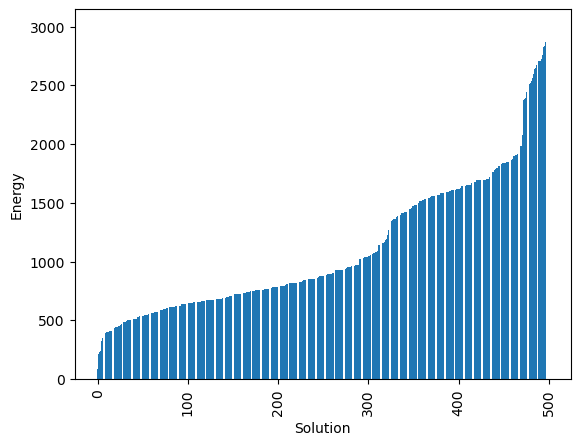

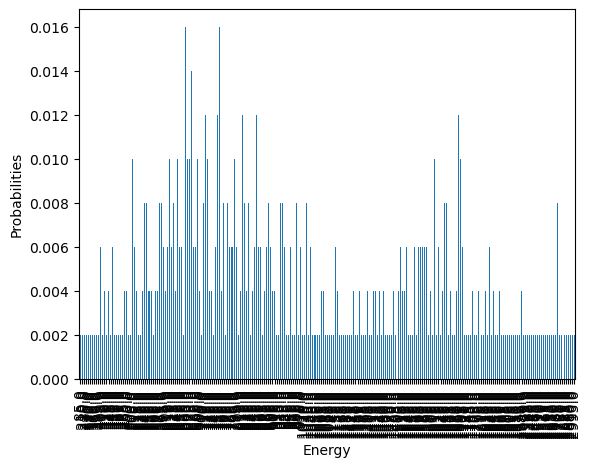

minimum energy: 85.0


In [124]:
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=500)
decoded_samples = model.decode_sampleset(sampleset)
best_sample = {k: v for k, v in sorted(sampleset.first.sample.items(), key=lambda item: int(item[0][7:-1]))}
print(best_sample)
plot_enumerate(sampleset)
plot_energies(sampleset)